# Importando bibliotecas necessárias para o projeto

In [1]:
from utils.install_pysddp import install_pysddp
import numpy as np
from cvxopt import matrix, solvers
from utils.calculo_regressao_linear import calculo_regressao_linear
from utils.calculo_previsao import calculo_previsao
import matplotlib.pyplot as plt

# Instalando PySDDP e configurando caminho do arquivo de entradas

In [2]:
## Vai instalar o PySDDP caso não esteja instalado
install_pysddp()
from PySDDP.Pen import Newave

## Caminho para o arquivo com as afluencias do Newave
file_path = './NewaveAugust2023/'

PMOAGO2023 = Newave(file_path)
## Seleciionar a usina desejada

PySDDP is already installed.
OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


# Escohendo Usina

In [4]:
Usina = PMOAGO2023.confhd.get('Furnas')

# Configurando o número de anos a serem analisados

In [5]:
# Total de anos (descartando os 2 anos mais recentes)
total_anos = (np.shape(Usina['vazoes'])[0]) - 2
# print("Total de anos: ", total_anos)

# Número de anos considerados (excluindo 1931 e os últimos dois anos - 2022 e 2023)
## 1931 é usado somente para calcular os phis de 1932, não calculamos seu erro
num_anos = total_anos - 1
# print("Número de anos considerados: ", num_anos)

# Dicionário de Meses 

In [6]:
meses = {'Jan': 0, 'Fev': 1, 'Mar': 2, 'Abr': 3, 'Mai': 4, 'Jun': 5,
         'Jul': 6, 'Ago': 7, 'Set': 8, 'Out': 9, 'Nov': 10, 'Dez': 11}

# Configurando ano de previsao e numero de $\phi$

In [7]:
anos_previsao = [2021]
phis_values = [5]

# Códido principal que chama as funcoes para previsão

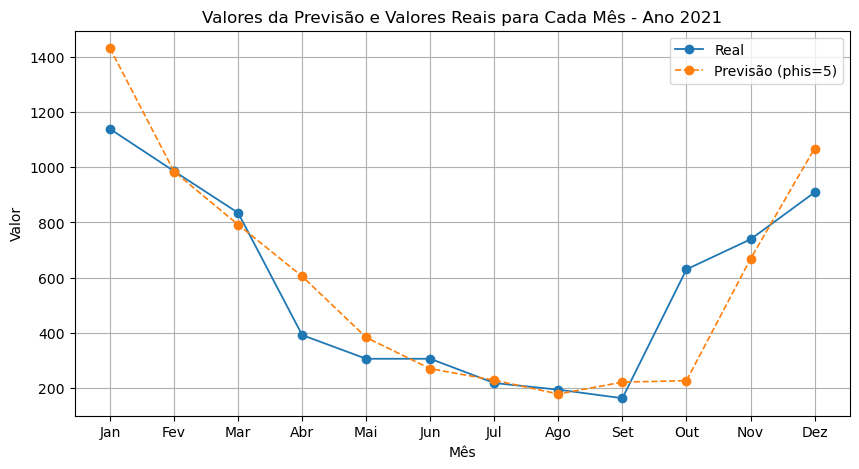

In [8]:
z_values = []
real_values = []

for ano_previsao in anos_previsao:
    real_values = []
    
    # Calculando os valores reais uma vez, já que eles são constantes
    for mes_name, mes_value in meses.items():
        real_value = Usina['vazoes'][ano_previsao-1931][mes_value]
        real_values.append(real_value)

    # Criando a figura
    plt.figure(figsize=(10, 5))

    # Plotando os valores reais
    plt.plot(meses.keys(), real_values, alpha=1, label='Real', marker='o', linewidth=1.3)

    # Loop para variar o número de phis e calcular as previsões
    for phi in phis_values:
        z_values = []
        for mes_name, mes_value in meses.items():
            resultado = calculo_regressao_linear(Usina, mes_value, phi, total_anos, num_anos, imprime=False)
            Z = calculo_previsao(Usina, resultado, mes_value, phi, ano_previsao)
            z_values.append(Z)

        plt.plot(meses.keys(), z_values, alpha=1, label=f'Previsão (phis={phi})', marker='o', linestyle='dashed', linewidth=1.2)

    plt.title(f'Valores da Previsão e Valores Reais para Cada Mês - Ano {ano_previsao}')
    plt.xlabel('Mês')
    plt.ylabel('Valor')
    plt.grid()
    plt.legend()
plt.show()